# Pix2Pix GAN ECG denoising

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import h5py
import os

snr_encoding = ['clean', '_6', '00', '06', '12', '18', '24']

class DB10s(torch.utils.data.Dataset):
    def __init__(self, mode):
        self.h5_list = []
        for root, dirs, files in os.walk('../../data_10s'):
            for f in files:
                path = os.path.join(root, f)
                with h5py.File(path, 'r') as h5:
                    if h5['MLII'][:].size != 3600:
                        continue
                abs_fname = os.path.join(root, f)
                if mode == 'train':
                    if '118e24' in abs_fname and abs_fname.split('/')[-2] != '118':
                        self.h5_list.append(abs_fname)
                elif mode == 'val':
                    if '119' in abs_fname and abs_fname.split('/')[-2] != '119':
                        self.h5_list.append(abs_fname)
        
    def __getitem__(self, i):
        fname = self.h5_list[i]
#         print(fname)
        with h5py.File(fname, 'r') as f:
            index = f['index'][()]
            MLII = torch.tensor(f['MLII'][:])
            SNR = torch.tensor(snr_encoding.index(f['SNR'][()]))
        
        clean_fname = self.get_clean_fname(i)
#         print(clean_fname)
        
        with h5py.File(clean_fname, 'r') as f:
            clean_index = f['index'][()]
            clean_MLII = torch.tensor(f['MLII'][:])
            clean_SNR = torch.tensor(snr_encoding.index(f['SNR'][()]))
        assert clean_index==index, 'clean image is not matched'
        assert clean_SNR.item() == 0, 'clean image is not clean(SNR)'
        return {
            'index': index,
            'MLII': MLII.float().reshape(1, -1),
            'clean': clean_MLII.float().reshape(1, -1),
            'SNR': SNR
        }
    def __len__(self):
        return len(self.h5_list)
    
    def get_clean_fname(self, index):
        fname = self.h5_list[index]
        clean_fname = fname.split('/')[:-1]
        clean_fname[-1] = clean_fname[-1][:3]
        clean_fname = '/'.join(clean_fname)
        clean_fname += '/'+fname.split('/')[-1]
        return clean_fname
        
dataset_train = DB10s('train')
dataset_val = DB10s('val')

# add a data to prevent batch truncating
dataset_train.h5_list.append(dataset_train.h5_list[-1])
dataset_val.h5_list.append(dataset_val.h5_list[-1])

## Clean and noisy signals

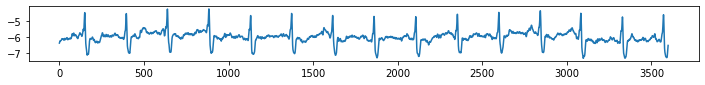

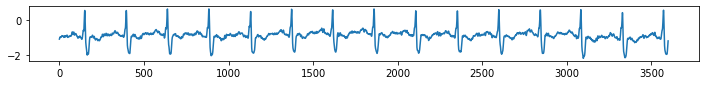

SNR: 6
Length: 3600
#Data: 181


In [2]:
import matplotlib.pyplot as plt
index, noisy, clean, SNR = dataset_train[41].values()

noisy = noisy.reshape(-1)
clean = clean.reshape(-1)

plt.figure(figsize=(12, 1))
plt.plot(range(len(noisy)), noisy)
plt.show()
plt.figure(figsize=(12, 1))
plt.plot(range(len(clean)), clean)
plt.show()
print('SNR:', SNR.item())
print('Length:', len(noisy))
print('#Data:', len(dataset_train))

In [3]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True, drop_last=False, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=64, shuffle=False, drop_last=False, num_workers=8)

## Pix2Pix GAN

### UNet block

In [4]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv1d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm1d(out_size))
        layers.append(nn.Tanh())
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose1d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm1d(out_size),
            nn.Tanh(),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        if x.shape[-1] != skip_input.shape[-1]:
            x = F.pad(x, (0, 1))
        x = torch.cat((x, skip_input), 1)

        return x

### Generator

In [5]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(128, out_channels, 4, padding=1),
            nn.ConstantPad1d((0, 1), 0),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

### Discrinimator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv1d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm1d(out_filters))
            layers.append(nn.Tanh())
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ConstantPad1d((0, 1), 0),
            nn.Conv1d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [7]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

## Training

### Configuration

In [8]:
# Num epochs
start_epoch, max_epoch = 1, 100

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Initialize generator and discriminator
generator = GeneratorUNet()
discriminator = Discriminator()

if torch.cuda.is_available():
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

### Train

[10/100] Loss_D: 0.4057 Loss_G: 30.0447


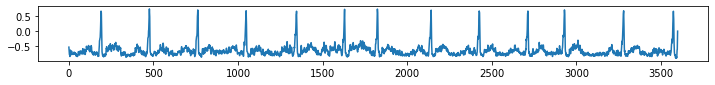

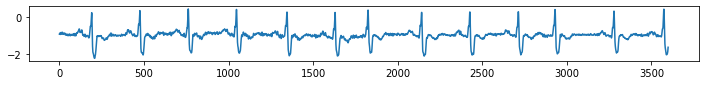

[20/100] Loss_D: 0.1393 Loss_G: 19.5545


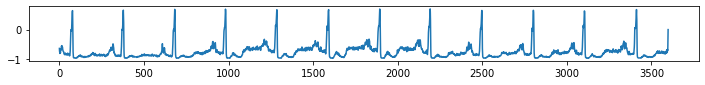

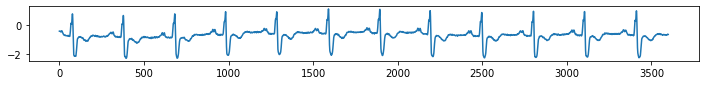

[30/100] Loss_D: 0.0805 Loss_G: 17.6209


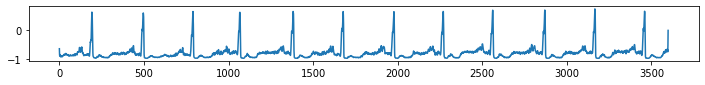

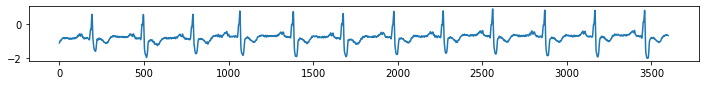

[40/100] Loss_D: 0.0777 Loss_G: 17.7448


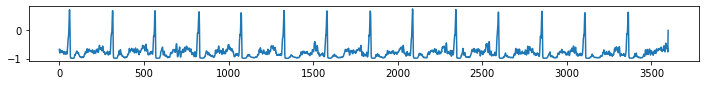

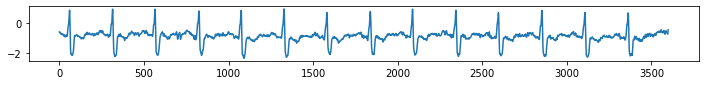

[50/100] Loss_D: 0.0583 Loss_G: 17.6153


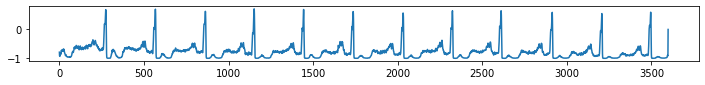

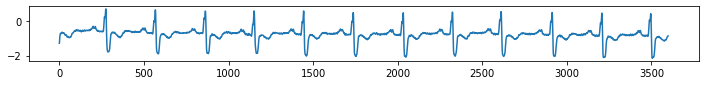

[60/100] Loss_D: 0.0731 Loss_G: 19.6931


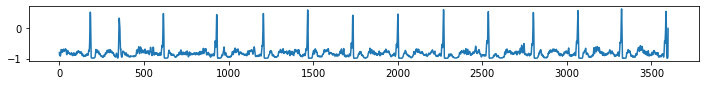

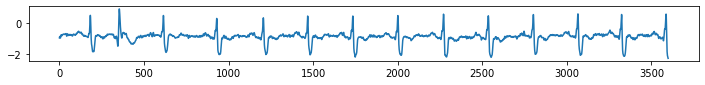

[70/100] Loss_D: 0.0486 Loss_G: 17.0990


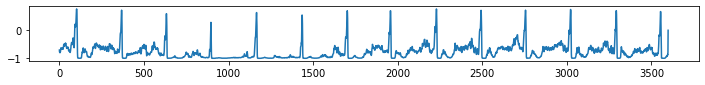

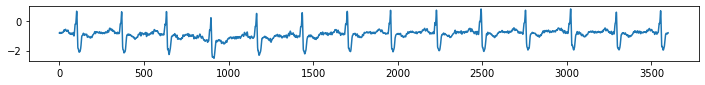

[80/100] Loss_D: 0.0354 Loss_G: 18.0300


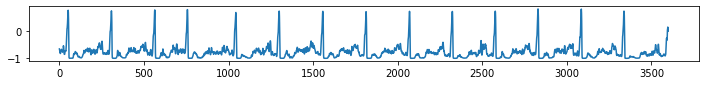

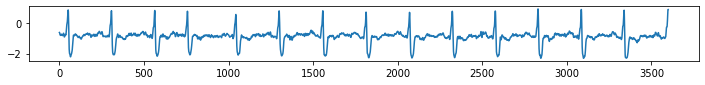

[90/100] Loss_D: 0.0581 Loss_G: 16.6502


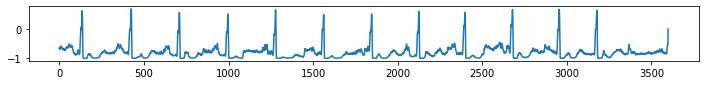

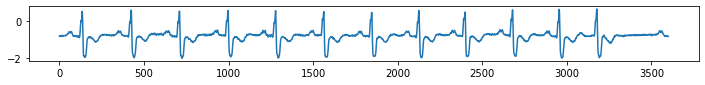

[100/100] Loss_D: 0.0327 Loss_G: 16.8708


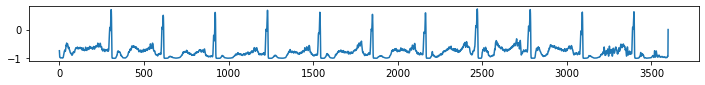

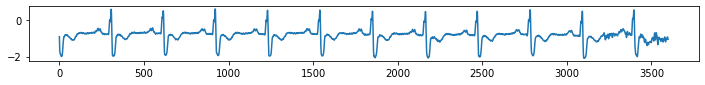

In [9]:
from tqdm import tqdm
import time

t = time.time()
loader = train_loader
log_step = max_epoch/10

for epoch in range(start_epoch, max_epoch + 1):
    for data in loader:
        real_noisy = data['MLII'].cuda()
        real_clean = data['clean'].cuda()
        # patch GAN 225
        valid = torch.ones((real_noisy.size(0), 1, 225), device='cuda', requires_grad=False).float()
        fake = torch.zeros((real_noisy.size(0), 1, 225), device='cuda', requires_grad=False).float()
        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        fake_clean = generator(real_noisy)
        pred_fake = discriminator(fake_clean, real_noisy)
        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_clean, real_clean)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_clean, real_noisy)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_clean.detach(), real_noisy)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()
        
    if epoch % log_step == 0:
        print('[{}/{}] Loss_D: {:.4f} Loss_G: {:.4f}'.format(
            epoch, max_epoch,
            loss_D.item(), loss_G.item()
        ))
        preview_g = fake_clean[40].cpu().detach().reshape(-1)
        preview_r = real_clean[40].cpu().detach().reshape(-1)
        for p in [preview_g, preview_r]:
            plt.figure(figsize=(12, 1))
            plt.plot(range(len(p)), p)
            plt.show()